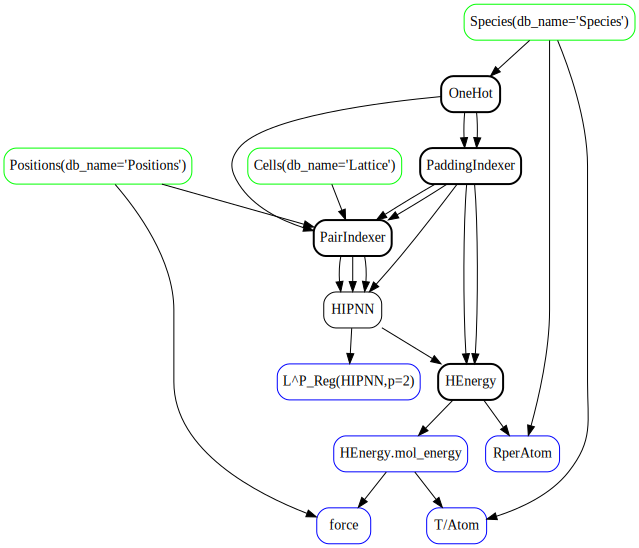

In [1]:
import torch
torch.set_default_dtype(torch.float32)

from hippynn.graphs import (find_relatives,find_unique_relative,
    get_subgraph, copy_subgraph, replace_node, IdxType,
    GraphModule)
from hippynn.graphs.gops import check_link_consistency
from hippynn.graphs.nodes.base import InputNode, MultiNode, AutoNoKw, ExpandParents
from hippynn.graphs.nodes.tags import Encoder, PairIndexer
from hippynn.graphs.nodes.physics import GradientNode, VecMag
from hippynn.graphs.nodes.inputs import SpeciesNode


from hippynn.experiment.serialization import load_checkpoint_from_cwd
from hippynn.tools import active_directory
import hippynn

try:
    with active_directory("./TEST_INP_MODEL", create=False):
        bundle = load_checkpoint_from_cwd(map_location='cpu',restart_db=False)
except FileNotFoundError:
    raise FileNotFoundError("Model not found, run lammps_example.py first!")

model = bundle["training_modules"].model
energy = model.node_from_name("HEnergy")

from hippynn.graphs.viz import visualize_graph_module, visualize_connected_nodes
from hippynn.graphs import replace_node
visualize_graph_module(model)

In [2]:
required_nodes = [energy]

why = "Generating LAMMPS Calculator interface"
subgraph = get_subgraph(required_nodes)

search_fn = lambda targ,sg: lambda n: n in sg and isinstance(n,targ)
pair_indexers = find_relatives(required_nodes, search_fn(PairIndexer, subgraph), why_desc=why)

new_required, new_subgraph = copy_subgraph(required_nodes, assume_inputed=pair_indexers, tag="LAMMPS")
pair_indexers = find_relatives(new_required, search_fn(PairIndexer, new_subgraph), why_desc=why)

species = find_unique_relative(new_required, search_fn(SpeciesNode, new_subgraph),why_desc=why)

encoder = find_unique_relative(species, search_fn(Encoder, new_subgraph), why_desc=why)
species_set = encoder.species_set.clone()

min_radius = max(p.dist_hard_max for p in pair_indexers)

In [3]:
in_pair_first = InputNode("(LAMMPS)pair_first")
in_pair_first._index_state = hippynn.graphs.IdxType.Pair
in_pair_second = InputNode("(LAMMPS)pair_second")
in_pair_second._index_state = hippynn.graphs.IdxType.Pair
in_pair_coord = InputNode("(LAMMPS)pair_coord")
in_pair_coord._index_state = hippynn.graphs.IdxType.Pair
in_nlocal = InputNode("(LAMMPS)nlocal")
in_nlocal._index_state = hippynn.graphs.IdxType.Scalar
pair_dist = VecMag("(LAMMPS)pair_dist", in_pair_coord)

new_inputs = [species,in_pair_first,in_pair_second,in_pair_coord,in_nlocal]

for pi in pair_indexers:
    replace_node(pi.pair_first, in_pair_first, disconnect_old=False)
    replace_node(pi.pair_second, in_pair_second, disconnect_old=False)
    replace_node(pi.pair_coord, in_pair_coord, disconnect_old=False)
    replace_node(pi.pair_dist, pair_dist, disconnect_old=False)
    pi.disconnect()

In [4]:
hipnn = model.node_from_name("HIPNN")
hipnn

Hipnn('HIPNN')<0x14599690e3a0>

In [5]:
class LocalAtomsEnergy(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, all_atom_energies, nlocal):
        local_atom_energies = all_atom_energies[:nlocal]
        total_local_energy = torch.sum(local_atom_energies)
        return local_atom_energies, total_local_energy


class LocalAtomEnergyNode(AutoNoKw, ExpandParents, MultiNode):
    _input_names = "all_atom_energies", "nlocal"
    _output_names = "local_atom_energies", "total_local_energy"
    _main_output = "total_local_energy"
    _output_index_states = None, IdxType.Scalar
    _auto_module_class = LocalAtomsEnergy

    _parent_expander.assertlen(2)
    _parent_expander.get_main_outputs()
    _parent_expander.require_idx_states(IdxType.Atoms, IdxType.Scalar)

    def __init__(self, name, parents, module='auto', **kwargs):
        parents = self.expand_parents(parents)
        super().__init__(name, parents, module=module, **kwargs)

In [6]:
energy, *new_required = new_required
local_atoms_energy = LocalAtomEnergyNode("(LAMMPS)local_atoms_energy", (energy.atom_energies, in_nlocal))

grad_rij = GradientNode("(LAMMPS)grad_rij", (local_atoms_energy.total_local_energy, in_pair_coord), -1)
implemented_nodes = local_atoms_energy.all_atom_energies, grad_rij

check_link_consistency((*new_inputs, *implemented_nodes))

True

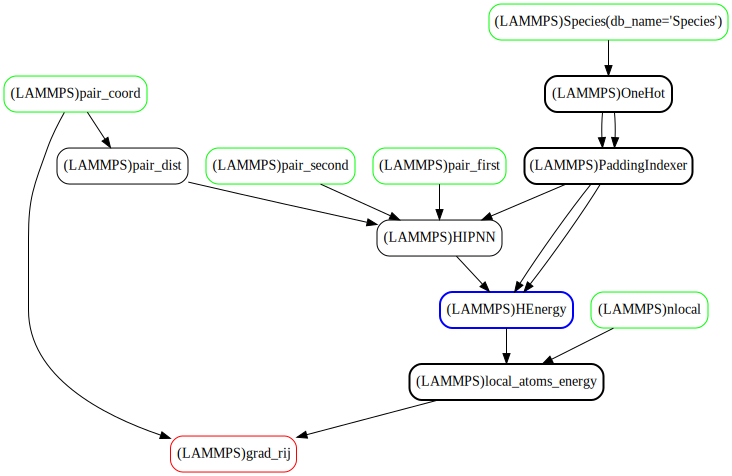

In [7]:
#visualize_graph_module(model, compactify=True)
visualize_connected_nodes([energy], compactify=True)

In [8]:
mod = GraphModule(new_inputs, implemented_nodes)
mod.eval()

GraphModule(
  Inputs: ("(LAMMPS)Species(db_name='Species')", '(LAMMPS)pair_first', '(LAMMPS)pair_second', '(LAMMPS)pair_coord', '(LAMMPS)nlocal') 
   Outputs: ('(LAMMPS)HEnergy.atom_energies', '(LAMMPS)grad_rij')
  (moddict): ModuleDict(
    (node0): OneHotSpecies()
    (node1): Idx(OneHot.encoding)
    (node2): VecMag()
    (node3): Idx(OneHot.nonblank)
    (node4): PaddingIndexer()
    (node5): Idx(PaddingIndexer.indexed_features)
    (node6): Idx(PaddingIndexer.mol_index)
    (node7): Idx(PaddingIndexer.real_atoms)
    (node8): Idx(PaddingIndexer.inv_real_atoms)
    (node9): Idx(PaddingIndexer.n_atoms_max)
    (node10): Idx(PaddingIndexer.atom_index)
    (node11): Hipnn(
      (activation): Softplus(beta=1, threshold=20)
      (blocks): ModuleList(
        (0): ModuleList(
          (0): ResNetWrapper(
            (activation): Softplus(beta=1, threshold=20)
            (base_layer): InteractLayer(
              (sensitivity): InverseSensitivityModule(
                (cutoff): Cos

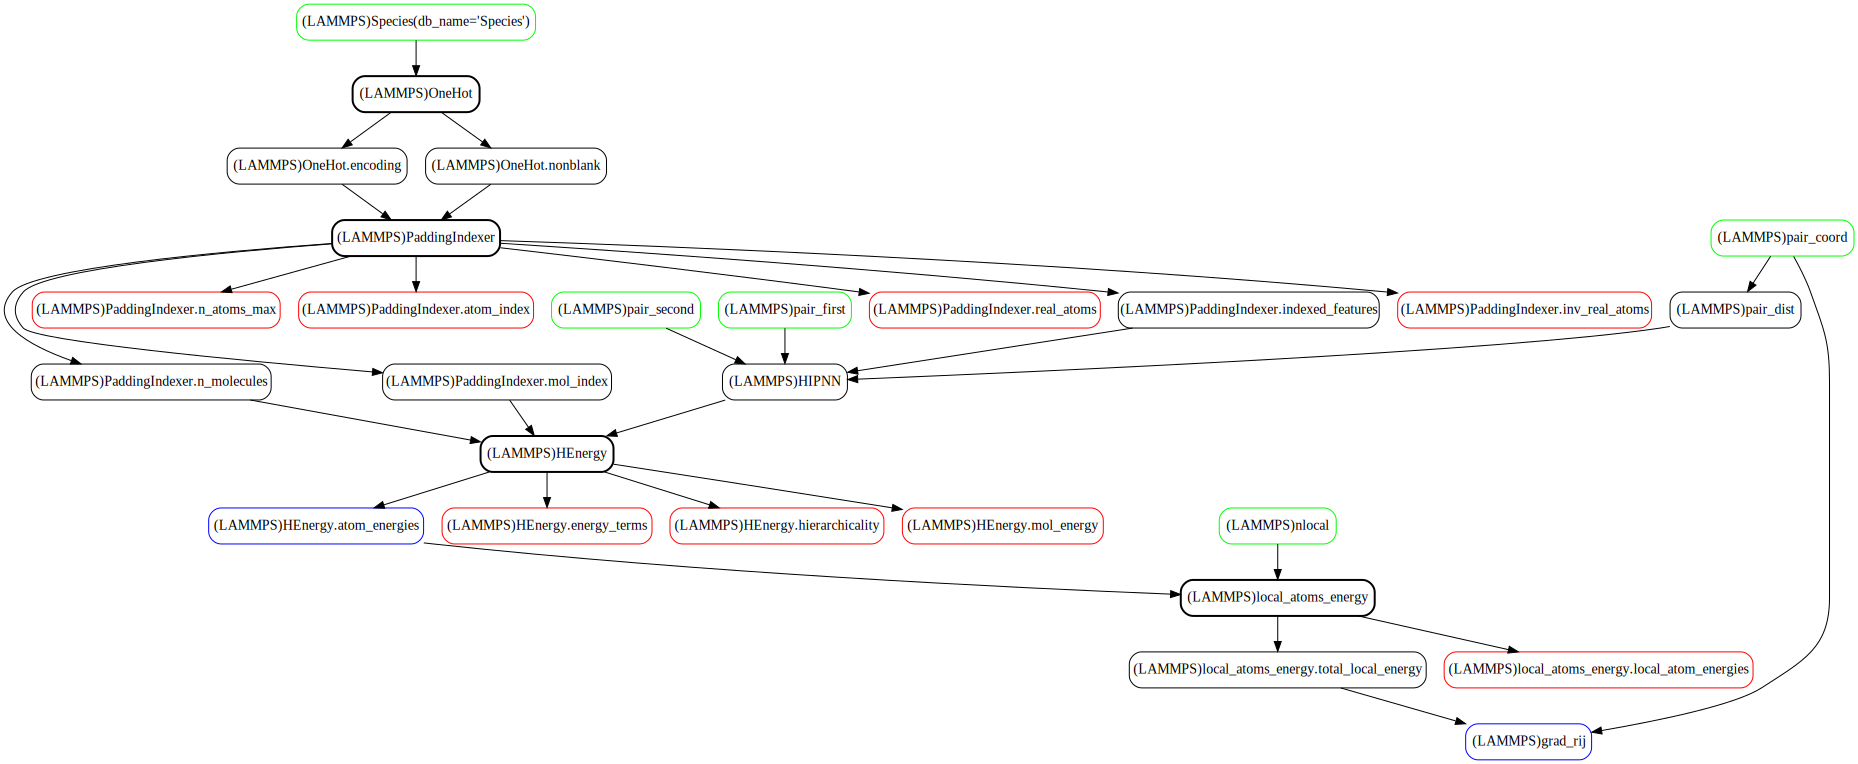

In [9]:
visualize_graph_module(mod, compactify=False)